### **Building a model that can assist in scaling up the implementation of NPIs based on kalman filter and machine learning algorithms.**
As we know the Covid19 is frightening all of us and has affected more than 185 countries, there is an urgent need in ways to control its further spread and help people saving lives. There is a lot of research work that is being done currently in the field of effectiveness of different mitigation measures for Covid19. In this notebook we describe an effective way that can be used to deploy npis in regions based on various parameters. We hope this work would help us fighting the covid19 pandemic in an effective way.

This map shows the present status of the coronavirus infections across the world.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
from ipywidgets import Image
f = open("/content/gdrive/My Drive/covid19h/c1.jpg", "rb")
image = f.read()
Image(value=image)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x06\x04\x0…

##**Goal/Tasks**
1) Our major goal is to provide guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases.

2) Rapid assessment of the likely efficacy of school closures, travel bans, bans on mass gatherings of various sizes, and other social distancing approaches.

3) Models of potential interventions to predict costs and benefits that take account of such factors as race, income, disability, age, geographic location, immigration status, housing status, employment status, and health insurance status.

4) The last point would be building a guideline model that will help control, any such pandemic and not let things go too far.

##**What all did we do?**
1) First step: Prediction of the outbreak, forecasting in terms of number of cases, number of deaths etc.

2) Second step: Prediction of the best-suited npi for the particular situation based on the previous history of implementations.

**Methods used for the first step**: We used regression techniques accompanied by a tool called Kalman filter which is found effective to give accurate predictions for such outbreaks.

Kalman filter: In statistics and control theory, Kalman filtering, also known as linear quadratic estimation (LQE), is an algorithm that uses a series of measurements observed over time, containing statistical noise and other inaccuracies, and produces estimates of unknown variables that tend to be more accurate than those based on a single measurement alone, by estimating a joint probability distribution over the variables for each timeframe. The filter is named after Rudolf E. Kálmán, one of the primary developers of its theory.

Source: https://en.wikipedia.org/wiki/Kalman_filter

**Methods used for the second step**: We have techniques like SMOTE(synthetic minority oversampling technique) to tackle our data-imbalance problem, various machine learning techniques like Random-Forest, KNearNeighboursClassifier, Decision trees etc. We have shown the performance of some of the best machine-learning techniques on our dataset in step two.

In [ ]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd
import cv2


In [ ]:

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url, error_bad_lines=False)
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url, error_bad_lines=False)
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url, error_bad_lines=False)

In [ ]:
# replacing the region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "Unites States")
death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "Unites States")
recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "Unites States")

In [ ]:
population=pd.read_csv('/content/gdrive/My Drive/tsv/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [ ]:
#merging the regions
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed=confirmed[confirmed.iloc[:,confirmed.shape[1]-3]>1000]
confirmed.iloc[:5,:]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,Population,region
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,"41,320,000",Algeria_nan
6,NaN,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,2,8,12,12,17,19,19,31,34,45,56,68,79,97,128,158,266,301,387,387,502,589,690,745,820,1054,1054,1133,1265,1451,1451,1554,1628,NaN,Argentina_nan
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,6,6,13,22,22,26,28,38,48,55,65,65,92,112,134,171,210,267,307,353,436,669,669,818,1029,1219,1405,1617,1791,2032,2032,2182,2298,2389,2493,2580,2637,2686,"7,544,000",Australia_New South Wales
14,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,1,1,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,7,9,9,10,10,10,11,11,15,18,21,21,36,49,57,71,94,121,121,121,229,355,355,411,466,520,574,685,769,821,917,968,1036,1085,1115,1135,1158,1191,"92,141",Australia_Victoria
16,NaN,Austria,47.5162,14.5501,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,...,14,18,21,29,41,55,79,104,131,182,246,302,504,655,860,1018,1332,1646,2013,2388,2814,3582,4474,5283,5588,6909,7657,8271,8788,9618,10180,10711,11129,11524,11781,12051,12297,12639,"8,822,000",Austria_nan


In [ ]:
#a function to jsut extract the time series information excluding other columns.
def create_ab(df):
  ab=df
  ab=ab.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ab.set_index('region')
  ab=ab.T
  ab.columns=ab.loc['region']
  ab=ab.drop('region')
  ab=ab.fillna(0)
  ab=ab.reindex(sorted(ab.columns), axis=1)
  return (ab)

In [ ]:
#creating time series data of confirmed, deaths, recovered cases.
ts=create_ab(confirmed)
ts_d=create_ab(death)
ts_rec=create_ab(recover)

In [ ]:
ts

region,Algeria_nan,Argentina_nan,Australia_New South Wales,Australia_Victoria,Austria_nan,Belgium_nan,Brazil_nan,Canada_Alberta,Canada_British Columbia,Canada_Ontario,Canada_Quebec,Chile_nan,China_Guangdong,China_Henan,China_Hubei,China_Hunan,China_Zhejiang,Colombia_nan,Croatia_nan,Czechia_nan,Denmark_nan,Dominican Republic_nan,Ecuador_nan,Egypt_nan,Estonia_nan,Finland_nan,France_nan,Germany_nan,Greece_nan,Iceland_nan,India_nan,Indonesia_nan,Iran_nan,Iraq_nan,Ireland_nan,Israel_nan,Italy_nan,Japan_nan,"Korea, South_nan",Luxembourg_nan,Malaysia_nan,Mexico_nan,Moldova_nan,Morocco_nan,Netherlands_nan,New Zealand_nan,Norway_nan,Pakistan_nan,Panama_nan,Peru_nan,Philippines_nan,Poland_nan,Portugal_nan,Qatar_nan,Romania_nan,Russia_nan,Saudi Arabia_nan,Serbia_nan,Singapore_nan,Slovenia_nan,South Africa_nan,Spain_nan,Sweden_nan,Switzerland_nan,Thailand_nan,Turkey_nan,Ukraine_nan,United Arab Emirates_nan,United Kingdom_nan,Unites States_nan
1/22/20,0,0,0,0,0,0,0,0,0,0,0,0,26,5,444,4,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1
1/23/20,0,0,0,0,0,0,0,0,0,0,0,0,32,5,444,9,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,1
1/24/20,0,0,0,0,0,0,0,0,0,0,0,0,53,9,549,24,43,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,2
1/25/20,0,0,0,0,0,0,0,0,0,0,0,0,78,32,761,43,62,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,2,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,7,0,0,0,0,2
1/26/20,0,0,3,1,0,0,0,0,0,1,0,0,111,83,1058,69,104,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,4,3,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,8,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4/3/20,1171,1265,2389,1085,11524,16770,9056,969,1174,3255,6101,3737,1514,1276,67802,1019,1260,1267,1079,4091,3757,1488,3368,985,961,1615,64338,91159,1613,1364,2567,1986,53183,820,4273,7428,119827,2617,10062,2612,3333,1510,591,791,15723,868,5370,2686,1475,1595,3018,3383,9886,1075,3183,4149,2039,1476,1114,934,1505,119199,6131,19606,1978,20921,1072,1264,38168,275586
4/4/20,1251,1451,2493,1115,11781,18431,10360,1075,1203,3630,6101,4161,1516,1276,67803,1019,1262,1406,1126,4472,4077,1488,3465,1070,1039,1882,89953,96092,1673,1417,3082,2092,55743,878,4604,7851,124632,3139,10156,2729,3483,1688,752,919,16627,950,5550,2818,1673,1746,3094,3627,10524,1325,3613,4731,2179,1624,1189,977,1585,126168,6443,20505,2067,23934,1225,1505,41903,308850
4/5/20,1320,1451,2580,1135,12051,19691,11130,1181,1203,4354,7944,4471,1524,1276,67803,1019,1263,1485,1182,4587,4369,1745,3646,1173,1097,1927,92839,100123,1735,1486,3588,2273,58226,961,4994,8430,128948,3139,10237,2804,3662,1890,864,1021,17851,1039,5687,3157,1801,2281,3246,4102,11278,1604,3864,5389,2402,1908,1309,997,1655,131646,6830,21100,2169,27069,1308,1799,47806,337072
4/6/20,1423,1554,2637,1158,12297,20814,12161,1250,1266,4347,8580,4815,1532,1276,67803,1019,1264,1579,1222,4822,4681,1828,3747,1322,1108,2176,98010,103374,1755,1562,4778,2491,60500,1031,5364,8904,132547,3654,10284,2843,3793,2143,965,1120,18803,1106,5865,3766,1988,2561,3660,4413,11730,1832,4057,6343,2605,2200,1375,1021,1686,136675,7206,21657,2220,30217,1319,2076,51608,366667


Text(0.5, 1.0, 'Daily Total Recoverd - Major areas')

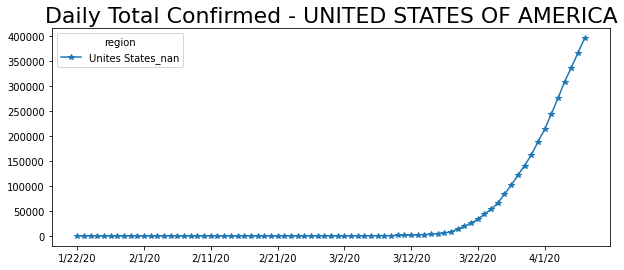

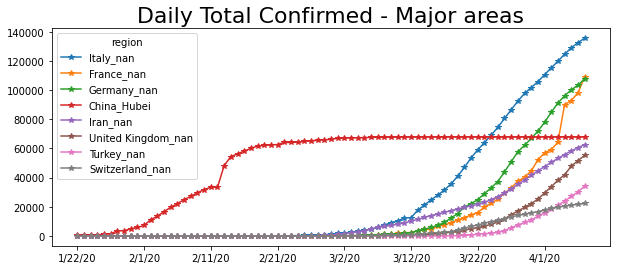

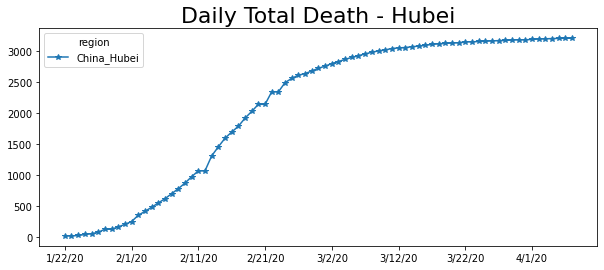

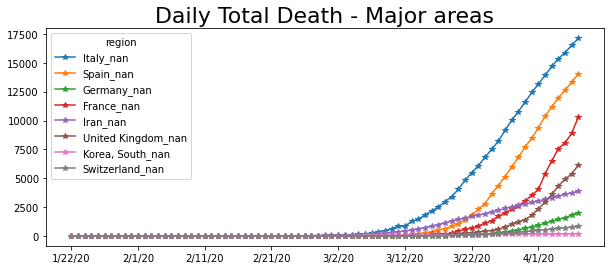

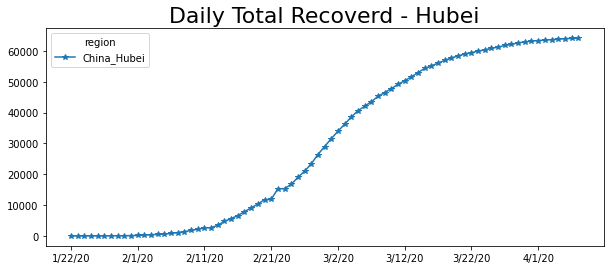

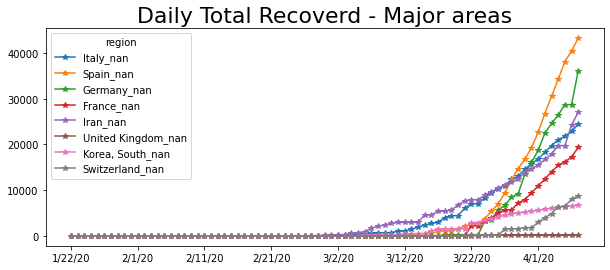

In [ ]:
import matplotlib.pyplot as plt
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,:1].plot(marker='*',figsize=(10,4)).set_title('Daily Total Confirmed - UNITED STATES OF AMERICA',fontdict={'fontsize': 22})
wes = p.iloc[:,:1]
p.iloc[:,2:10].plot(marker='*',figsize=(10,4)).set_title('Daily Total Confirmed - Major areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts.mean().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,:1].plot(marker='*',figsize=(10,4)).set_title('Daily Total Death - Hubei',fontdict={'fontsize': 22})
p_d.iloc[:,2:10].plot(marker='*',figsize=(10,4)).set_title('Daily Total Death - Major areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts.mean().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,:1].plot(marker='*',figsize=(10,4)).set_title('Daily Total Recoverd - Hubei',fontdict={'fontsize': 22})
p_r.iloc[:,2:10].plot(marker='*',figsize=(10,4)).set_title('Daily Total Recoverd - Major areas',fontdict={'fontsize': 22})

In [ ]:
wes.T.to_csv(r'/content/gdrive/My Drive/tsv/usaconf.csv')

In [ ]:
ts_r=ts.reset_index()
ts_r=ts_r.rename(columns = {'index':'date'})
ts_r['date']=pd.to_datetime(ts_r['date'] ,errors ='coerce')
ts_r.to_csv(r'/content/gdrive/My Drive/tsv/ts_r2.csv')

In [ ]:
#importing rpy2 package for using R.
import rpy2
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [ ]:
%%R
install.packages('pracma')
install.packages('reshape')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/pracma_2.2.9.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 400551 bytes (391 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write

In [ ]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/content/gdrive/My Drive/tsv/ts_r2.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  date = col_date(format = "")
)

R[write to console]: See spec(...) for full column specifications.



In [ ]:
p=%R pred_all


In [ ]:
############ Merge R output due to package problem
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
p.set_index(temp.index,inplace=True)
#temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']


In [ ]:
w=pd.read_csv('/content/gdrive/My Drive/tsv/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')
#w['date']=pd.to_datetime(w['date'],errors ='coerce')

w_forecast=pd.read_csv('/content/gdrive/My Drive/tsv/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

In [ ]:
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [ ]:
t.iloc[:,10:11]

""
0
1
2
3
4
...
5308
5309
5310
5311


In [ ]:
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is t.iloc[i-2,1]):
    t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
    t.iloc[i,6]=(t.iloc[i-1,2]/t.iloc[i-2,2]-1)*100
    t.iloc[i,9]=t.iloc[i-1,2]
  if(t.iloc[i,1] is t.iloc[i-4,1]):
    t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
    t.iloc[i,7]=(t.iloc[i-1,2]/t.iloc[i-4,2]-1)*100
  if(t.iloc[i,1] is t.iloc[i-8,1]):
    t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
    t.iloc[i,8]=(t.iloc[i-1,2]/t.iloc[i-8,2]-1)*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)
t['kalman_prediction']=round(t['kalman_prediction'])
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(1)
train['population']=train['population'].astype('int32')
train['infected_rate'] =train['last_day']/train['population']*10000
train=train.merge(w,how='left',on=['date','region'])
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in long_scalars
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':


         region           mse         rmse          mae
14  China_Hubei  6.559409e+07  8099.018076  1970.947368


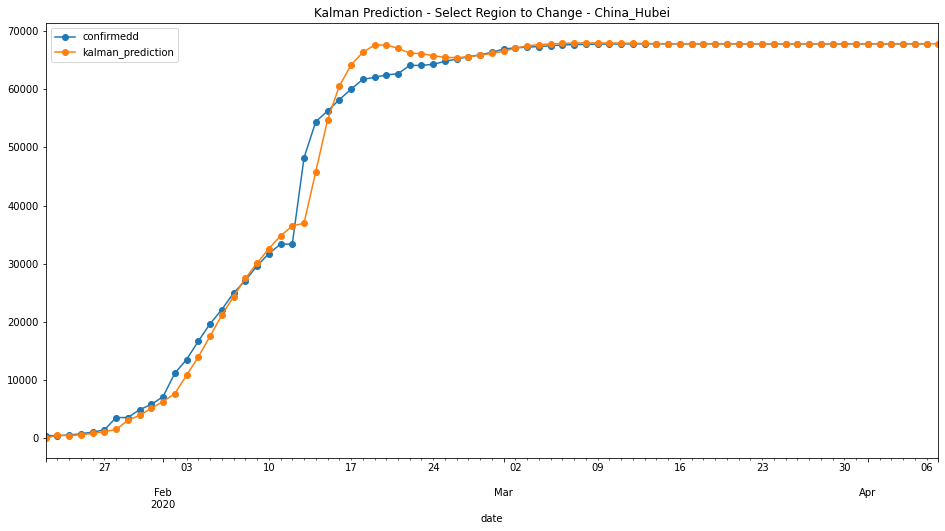

In [ ]:
# Select region
region='China_Hubei'
place=0

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
p=p.rename(columns = {'confirmed':'confirmedd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))
print(evaluation[evaluation['region']==p.iloc[0,0]])


In [ ]:
for i in range(1,len(t)):

    print(t.iloc[i,2])

Streaming output truncated to the last 5000 lines.
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
3
3
9
14
18
21
29
41
55
79
104
131
182
246
302
504
655
860
1018
1332
1646
2013
2388
2814
3582
4474
5283
5588
6909
7657
8271
8788
9618
10180
10711
11129
11524
11781
12051
12297
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
8
13
23
50
109
169
200
239
267
314
314
559
689
886
1058
1243
1486
1795
2257
2815
3401
3743
4269
4937
6235
7284
9134
10836
11899
12775
13964
15348
16770
18431
19691
20814
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
2
2
2
2
4
4
13
13
20
25
31
38
52
151
151
162
200
321
372
621
793
1021
1546
1924
2247
2554
2985
3417
3904
4256
4579
5717
6836
8044
9056
10360
11130
12161
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
4
7
7
19
19
29
29
39
56
74
97
119
146
195
259
301
359
358
486
542
542
621
661
690
754
969
969
1075
1181
1250
0
0
0
0
0
0
0
1
1
1
1
1
1
1

In [ ]:
region='China_Shanghai'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    ex=np.array(t.iloc[i-len(ts):i,10])
    pred=np.array(t.iloc[i-len(ts):i,2])
    evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))
print(evaluation[evaluation['region']==p.iloc[0,0]])

IndexError: ignored

       region            mse        rmse         mae
30  India_nan  325807.921053  570.795866  111.078947


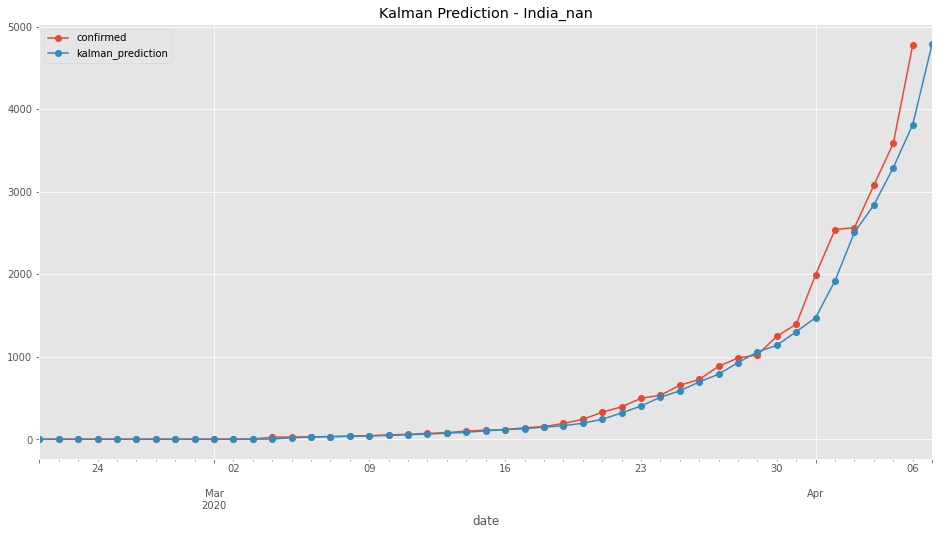

In [ ]:
plt.style.use('ggplot')
# Select region
#region= 'Israel_nan'
#region='Brazil_nan'
#region='Unites States_nan'
region='India_nan'
#region='China_Hubei'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    ex=np.array(t.iloc[i-len(ts):i,10])
    pred=np.array(t.iloc[i-len(ts):i,2])
    evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
p=p.rename(columns = {'confirmed':'confirmed'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[30:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - {}'.format(p.iloc[0,0]))
print(evaluation[evaluation['region']==p.iloc[0,0]])


In [ ]:
p.iloc[30:,1:]

,confirmed,kalman_prediction
date,,
2020-02-21,3.0,3.0
2020-02-22,3.0,3.0
2020-02-23,3.0,3.0
2020-02-24,3.0,3.0
2020-02-25,3.0,3.0
2020-02-26,3.0,3.0
2020-02-27,3.0,3.0
2020-02-28,3.0,3.0
2020-02-29,3.0,3.0


By doing the below mentioned steps, we are trying to find out the importance of each variables using random forest classifier.

In [ ]:
!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='8G')
import numpy as np
from sklearn.linear_model import LinearRegression

     |████████████████████████████████| 129.5MB 61kB/s 
  Created wheel for h2o: filename=h2o-3.30.0.1-py2.py3-none-any.whl size=129557718 sha256=17fd09c42f1ce39fd230847c149571732332935ced84f1e7cd23087a09b6bbf2
  Stored in directory: /root/.cache/pip/wheels/db/42/63/d118d7218432054da842f5d10bd4f99e978bde0931164e6c7a
Successfully built h2o
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpqkzndbii
  JVM stdout: /tmp/tmpqkzndbii/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpqkzndbii/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
C

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_unknownUser_ra6d86
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [ ]:
train=train.fillna(0) 
train_df=train[train['date']<'2020-02-17']
boots=train_df[train_df['date']>='2020-02-14'] #to give more weight for recent days
train_df=train_df.append([boots[boots['date']>='2020-02-14']]*1000,ignore_index=True)
train_df_hubei=train_df[train_df['region']=='China_Hubei']
test=train[train['date']>='2020-02-17']
test=test[test['date']<'2020-02-19']

In [ ]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            # '1_day_change_rate', 
            #'3_day_change_rate',
             '7_day_change_rate', 
            'last_day', 'kalman_prediction','infected_rate', 'min', 'max'
          ]

Here we are Using the kalmin filtered inputs for our linear regression model, which much accurate due to the previous time step.

In [ ]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values
#pred2.iloc[:55]

In [ ]:
train_h20 = h2o.H2OFrame(train_df)
train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
training_columns = ['region','1_day_change', '3_day_change', '7_day_change', '1_day_change_rate', '3_day_change_rate',
                    '7_day_change_rate', 'last_day', 'kalman_prediction','infected_rate', 'min', 'max'
                   ]                 
# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)
model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


Feature importance for the Hubei model using RF

In [ ]:
model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF

,variable,relative_importance,scaled_importance,percentage
0,kalman_prediction,3.333278e+12,1.000000,0.241271
1,last_day,3.104993e+12,0.931513,0.224747
2,infected_rate,2.381595e+12,0.714490,0.172385
3,3_day_change,1.909147e+12,0.572754,0.138189
4,7_day_change,1.398378e+12,0.419520,0.101218
5,1_day_change,7.164111e+11,0.214927,0.051856
6,3_day_change_rate,3.820265e+11,0.114610,0.027652
7,7_day_change_rate,2.988950e+11,0.089670,0.021635
8,1_day_change_rate,1.425066e+11,0.042753,0.010315
9,min,8.201871e+10,0.024606,0.005937


The correlation matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Correlation Matrix


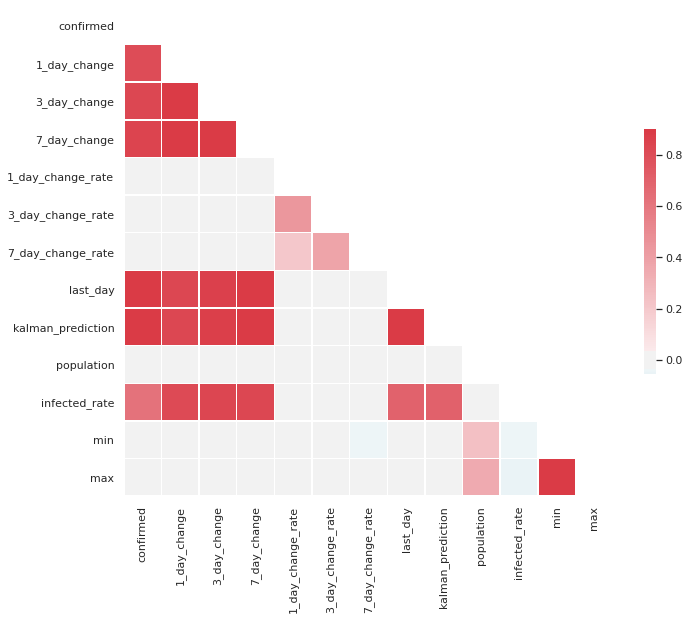

In [ ]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [ ]:

print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.809247
3_day_change         0.830578
7_day_change         0.841900
1_day_change_rate   -0.018472
3_day_change_rate   -0.020900
7_day_change_rate   -0.015383
last_day             0.918940
kalman_prediction    0.917419
population          -0.002823
infected_rate        0.617521
min                  0.015598
max                  0.031720
Name: confirmed, dtype: float64


A graph showing the variation of minimum and maximum temperature.

Text(0.5, 1.0, 'Daily Min/Max Temperature - India')

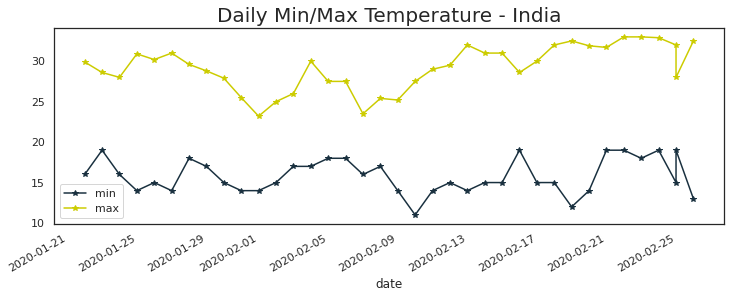

In [ ]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
p=p[p['region']=='India_nan']
p.iloc[:37,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - India',fontdict={'fontsize': 20})


A table showing more infected areas vs temperature.

In [ ]:
avg_temp=train[['region','confirmed','min','max']]  # from 17-02-20
avg_temp=avg_temp.groupby(by='region').mean()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:10,1:])

Most infected Areas Avg Temperature
                         min        max
region                                 
China_Hubei         7.146753  13.976623
Unites States_nan   0.000000   0.000000
Italy_nan           7.029114  15.350633
Spain_nan           5.911392  14.755696
Germany_nan         1.579545   5.056818
Iran_nan            5.317722  15.481013
France_nan          2.525000   8.878409
United Kingdom_nan  0.000000   0.000000
Korea, South_nan    0.000000   0.000000
Switzerland_nan    -1.509524   1.813095


## **X Day ahead prediction using kalman filter**

Using the R interface again


In [ ]:

%%R
install.packages('reshape')

(as ‘lib’ is unspecified)







	‘/tmp/RtmpaduWFA/downloaded_packages’



In [ ]:
%%R
require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/content/gdrive/My Drive/tsv/ts_r2.csv")
all$X1<-NULL
for (i in 1:30) { # Set i days prediction
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}


cols(
  .default = col_double(),
  date = col_date(format = "")
)




In [ ]:
all_new=%R all_new

In [ ]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Region to Change - India_nan')

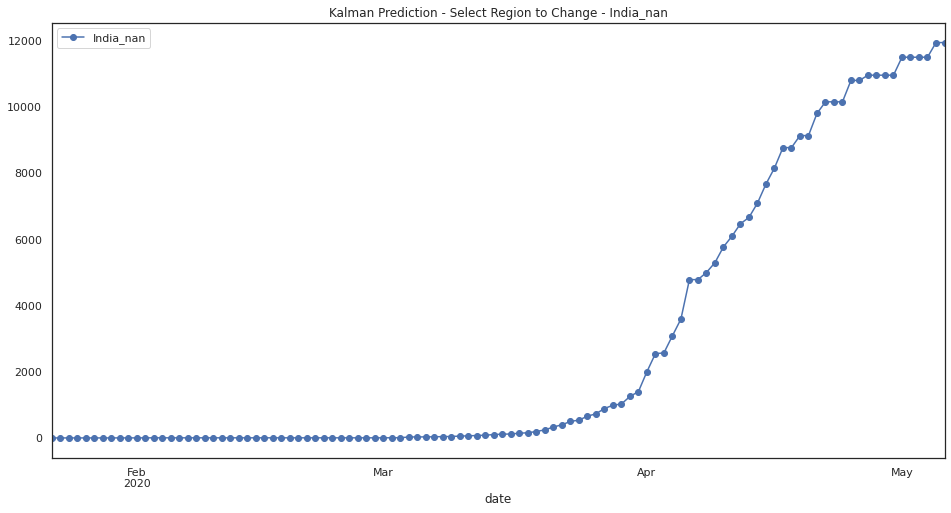

In [ ]:
# Select region
region=['date','China_Anhui', 'China_Beijing',
       'China_Chongqing', 'China_Fujian', 'China_Gansu',
       'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
       'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan','China_Hunan', 
       'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
       'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
       'China_Shandong', 'China_Shanghai', 'China_Shanxi',
       'China_Sichuan',  'China_Xinjiang',
       'China_Yunnan', 'China_Zhejiang', 
        'Hong Kong_Hong Kong','Japan_nan','Others_Diamond Princess cruise ship']
#p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
#p_kalman=p_kalman.set_index(['date'])
#p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')

p_kalman2=all_new[['date','India_nan']]
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p_kalman2.columns[0]))


In [ ]:
#getting the last prediction-30 day
p_kalman2.iloc[103:104,:]

,India_nan
date,
2020-05-04,11491.0


In [ ]:
all_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106 entries, 1 to 106
Data columns (total 70 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       106 non-null    datetime64[ns]
 1   Algeria_nan                106 non-null    float64       
 2   Argentina_nan              106 non-null    float64       
 3   Australia_New South Wales  106 non-null    float64       
 4   Australia_Victoria         106 non-null    float64       
 5   Austria_nan                106 non-null    float64       
 6   Belgium_nan                106 non-null    float64       
 7   Brazil_nan                 106 non-null    float64       
 8   Canada_Alberta             106 non-null    float64       
 9   Canada_British Columbia    106 non-null    float64       
 10  Canada_Ontario             106 non-null    float64       
 11  Canada_Quebec              106 non-null    float64       
 12  Chile_nan    

All the countries having the predictions

In [ ]:
for col in all_new.columns: 
    print(col) 

date
Algeria_nan
Argentina_nan
Australia_New South Wales
Australia_Victoria
Austria_nan
Belgium_nan
Brazil_nan
Canada_Alberta
Canada_British Columbia
Canada_Ontario
Canada_Quebec
Chile_nan
China_Guangdong
China_Henan
China_Hubei
China_Hunan
China_Zhejiang
Colombia_nan
Croatia_nan
Czechia_nan
Denmark_nan
Dominican Republic_nan
Ecuador_nan
Egypt_nan
Estonia_nan
Finland_nan
France_nan
Germany_nan
Greece_nan
Iceland_nan
India_nan
Indonesia_nan
Iran_nan
Iraq_nan
Ireland_nan
Israel_nan
Italy_nan
Japan_nan
Korea, South_nan
Luxembourg_nan
Malaysia_nan
Mexico_nan
Morocco_nan
Netherlands_nan
New Zealand_nan
Norway_nan
Pakistan_nan
Panama_nan
Peru_nan
Philippines_nan
Poland_nan
Portugal_nan
Qatar_nan
Romania_nan
Russia_nan
Saudi Arabia_nan
Serbia_nan
Singapore_nan
Slovenia_nan
South Africa_nan
Spain_nan
Sweden_nan
Switzerland_nan
Thailand_nan
Turkey_nan
Ukraine_nan
United Arab Emirates_nan
United Kingdom_nan
Unites States_nan


# **Iterative Regression**

In [ ]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
  if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
    t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
  if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
    t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
    t_iter.iloc[i,6]=(t_iter.iloc[i-1,2]/t_iter.iloc[i-2,2]-1)*100
    t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
  if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
    t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
    t_iter.iloc[i,7]=(t_iter.iloc[i-1,2]/t_iter.iloc[i-4,2]-1)*100
  if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
    t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
    t_iter.iloc[i,8]=(t_iter.iloc[i-1,2]/t_iter.iloc[i-8,2]-1)*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])
test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(1)
test_iter['population']=test_iter['population'].astype('int32')
test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])
test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
  if(np.isnan(test_iter.iloc[i,13])):
    if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
      test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
      test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


In [ ]:
test_iter=test_iter.fillna(0) 

In [ ]:
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values
for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
      if(pred.iloc[i,0]<pred.iloc[i-1,1]):
        pred.iloc[i,0]=pred.iloc[i-1,1]
pred = pred.pivot_table(index='date',columns='region',values='prediction') # pivot pred df

In [ ]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 107 entries, 2020-01-22 to 2020-05-07
Data columns (total 69 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Algeria_nan                107 non-null    float64
 1   Argentina_nan              107 non-null    float64
 2   Australia_New South Wales  107 non-null    float64
 3   Australia_Victoria         107 non-null    float64
 4   Austria_nan                107 non-null    float64
 5   Belgium_nan                107 non-null    float64
 6   Brazil_nan                 107 non-null    float64
 7   Canada_Alberta             107 non-null    float64
 8   Canada_British Columbia    107 non-null    float64
 9   Canada_Ontario             107 non-null    float64
 10  Canada_Quebec              107 non-null    float64
 11  Chile_nan                  107 non-null    float64
 12  China_Guangdong            107 non-null    float64
 13  China_Henan                107 

In [ ]:
for col in pred.columns: 
    printcol

NameError: ignored

In [ ]:
d = pred
d = d.T
d.to_csv(r'/content/gdrive/My Drive/tsv/pred.csv')

In [ ]:
a = pred['India_nan'] 
a = a.to_frame()

In [ ]:
a = a.T

In [ ]:
a.info()

In [ ]:
listofdate = []
for col in a.columns:
    listofdate.append(col)

In [ ]:
#Now displaying all the dates
listofdate# we can create a list of predictions like this and also automate this

In [ ]:
p2=pred['India_nan']
p2.plot(marker='o',figsize=(16,8),title ='India Prediction')

In [ ]:
pred